In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import math

from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares
from scipy.optimize import leastsq

from sklearn import linear_model
from numpy.linalg import norm

from numpy import dot
from numpy.linalg import norm

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(10)

from scipy import stats

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
random.seed(10)
#true_para = np.array([0.31, -0.6, 0.29, -0.01, 0.011, 0.009, -0.01, -0.012, 0.015, 0.3, 0.5, 0.2, 100])
#true_para = np.array([0.21, -0.4, 0.19, -0.02, 0.016, 0.01, -0.014, -0.017, 0.02, 0.3, 0.5, 0.2, 100])
time_seg = 1
cur_time = np.arange(0, 10+time_seg, time_seg)
num_point = len(cur_time)
num_iteration = 100
num_run = 20
n0_est = 0.02
#n0_est = 20000000000

distance_sq = [None] * num_run
distance_trf = [None] * num_run
distance_lm = [None] * num_run


df = pd.read_csv('../Data/cheese_relative.csv')
real_value = pd.DataFrame(dict(
    n1_relative = df["C"],
    n2_relative = df["D"],
    n3_relative = df["G"],
    n4_relative = df["L"],
    n5_relative = df["Y"]
))
    
real_value

,n1_relative,n2_relative,n3_relative,n4_relative,n5_relative
0,0.847573,0.002967,0.000930,0.145856,0.002674
1,0.826420,0.028994,0.000650,0.124234,0.019702
2,0.561663,0.240270,0.000387,0.092901,0.104779
3,0.189421,0.686109,0.010672,0.031358,0.082440
4,0.095991,0.694262,0.127890,0.015891,0.065965
5,0.065566,0.604439,0.223987,0.004065,0.101944
6,0.053760,0.440415,0.264017,0.004259,0.237549
7,0.248557,0.298750,0.314174,0.005229,0.133290
8,0.476673,0.160271,0.202905,0.021653,0.138497
9,0.780469,0.061897,0.097049,0.006120,0.054465


In [5]:
min_distance = np.inf
min_theta = [[0]*31]
method_used = "None"

for k in range (num_run):

    from numba import njit


    @njit
    def rhs(X, t, theta):
        # unpack parameters
        x, y, z, v, w, n = X
        r1, r2, r3, r4, r5, b12, b13, b14, b15, b21, b23, b24, b25, b31, b32, b34, b35, b41, b42, b43, b45, b51, b52, b53, b54, x0, y0, z0, v0, w0, n0 = theta
        # equations
        dn_dt = r1*x*n + b12*x*y*n*n + b13*x*z*n*n + b14*x*v*n*n + b15*x*w*n*n + r2*y*n + b21*x*y*n*n + b23*y*z*n*n + b24*y*v*n*n + b25*y*w*n*n + r3*z*n + b31*x*z*n*n + b32*y*z*n*n + b34*z*v*n*n + b35*z*w*n*n + r4*v*n + b41*v*x*n*n + b42*v*y*n*n + b43*v*z*n*n + b45*v*w*n*n + r5*w*n + b51*w*x*n*n + b52*w*y*n*n + b53*w*z*n*n + b54*w*v*n*n
        dx_dt = (r1*x*n + b12*x*y*n*n + b13*x*z*n*n + b14*x*v*n*n + b15*x*w*n*n - x*dn_dt)/n
        dy_dt = (r2*y*n + b21*x*y*n*n + b23*y*z*n*n + b24*y*v*n*n + b25*y*w*n*n - y*dn_dt)/n
        dz_dt = (r3*z*n + b31*x*z*n*n + b32*y*z*n*n + b34*z*v*n*n + b35*z*w*n*n - z*dn_dt)/n
        dv_dt = (r4*v*n + b41*v*x*n*n + b42*v*y*n*n + b43*v*z*n*n + b45*v*w*n*n - v*dn_dt)/n
        dw_dt = (r5*w*n + b51*w*x*n*n + b52*w*y*n*n + b53*w*z*n*n + b54*w*v*n*n - w*dn_dt)/n
        return [dx_dt, dy_dt, dz_dt, dv_dt, dw_dt, dn_dt]
    
    
    data = pd.DataFrame(dict(
    n1_relative = np.array(real_value.iloc[:, 0]),
    n2_relative = np.array(real_value.iloc[:, 1]),
    n3_relative = np.array(real_value.iloc[:, 2]),
    n4_relative = np.array(real_value.iloc[:, 3]),
    n5_relative = np.array(real_value.iloc[:, 4]),
    n1_abs = np.array(real_value.iloc[:, 0]) * n0_est,
    n2_abs = np.array(real_value.iloc[:, 1]) * n0_est,
    n3_abs = np.array(real_value.iloc[:, 2]) * n0_est, 
    n4_abs = np.array(real_value.iloc[:, 3]) * n0_est, 
    n5_abs = np.array(real_value.iloc[:, 4]) * n0_est, 
    ))
    
    for i in range (num_point-1):
        data.loc[num_point+i] = (1/time_seg)*np.log(data.loc[i+1]) - (1/time_seg)*np.log(data.loc[i])
    
    
    x = pd.DataFrame(data.loc[0:num_point-2, ["n2_abs", "n3_abs", "n4_abs", "n5_abs"]])
    y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n1_abs"])

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    r1_ini = regr.intercept_[0]
    b12_ini = regr.coef_[0,0]
    b13_ini = regr.coef_[0,1]
    b14_ini = regr.coef_[0,2]
    b15_ini = regr.coef_[0,3]
    
    x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n3_abs", "n4_abs", "n5_abs"]])
    y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n2_abs"])

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    r2_ini = regr.intercept_[0]
    b21_ini = regr.coef_[0,0]
    b23_ini = regr.coef_[0,1]
    b24_ini = regr.coef_[0,2]
    b25_ini = regr.coef_[0,3]

    x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n2_abs", "n4_abs", "n5_abs"]])
    y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n3_abs"])

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    r3_ini = regr.intercept_[0]
    b31_ini = regr.coef_[0,0]
    b32_ini = regr.coef_[0,1]
    b34_ini = regr.coef_[0,2]
    b35_ini = regr.coef_[0,3]

    x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n2_abs", "n3_abs", "n5_abs"]])
    y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n4_abs"])

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    r4_ini = regr.intercept_[0]
    b41_ini = regr.coef_[0,0]
    b42_ini = regr.coef_[0,1]
    b43_ini = regr.coef_[0,2]
    b45_ini = regr.coef_[0,3]

    x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n2_abs", "n3_abs", "n4_abs"]])
    y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n5_abs"])

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    r5_ini = regr.intercept_[0]
    b51_ini = regr.coef_[0,0]
    b52_ini = regr.coef_[0,1]
    b53_ini = regr.coef_[0,2]
    b54_ini = regr.coef_[0,3]
    
    theta_estimate = np.array([r1_ini, r2_ini, r3_ini, r4_ini, r5_ini, b12_ini, b13_ini, b14_ini, b15_ini, b21_ini, b23_ini, b24_ini, b25_ini, b31_ini, b32_ini, b34_ini, b35_ini, b41_ini, b42_ini, b43_ini, b45_ini, b51_ini, b52_ini, b53_ini, b54_ini, real_value.iloc[0, 0], real_value.iloc[0, 1], real_value.iloc[0, 2], real_value.iloc[0, 3], real_value.iloc[0, 4], n0_est])

    theta_glvr = theta_estimate
    
    theta = theta_estimate

    time = cur_time

     # call Scipy's odeint function, 
    x_y_hat = odeint(func=rhs, y0=theta[-6:], t=time, args=(theta,))
    data = pd.DataFrame(dict(
        n1_relative = np.array(x_y_hat[:, 0]),
        n2_relative = np.array(x_y_hat[:, 1]),
        n3_relative = np.array(x_y_hat[:, 2]),
        n4_relative = np.array(x_y_hat[:, 3]),
        n5_relative = np.array(x_y_hat[:, 4]),
        absolute_sum = np.array(x_y_hat[:, 5]),
        n1_abs = np.array(real_value.iloc[:, 0]) * np.array(x_y_hat[:, 5]),
        n2_abs = np.array(real_value.iloc[:, 1]) * np.array(x_y_hat[:, 5]),
        n3_abs = np.array(real_value.iloc[:, 2]) * np.array(x_y_hat[:, 5]), 
        n4_abs = np.array(real_value.iloc[:, 3]) * np.array(x_y_hat[:, 5]), 
        n5_abs = np.array(real_value.iloc[:, 4]) * np.array(x_y_hat[:, 5]), 
        
    ))
    for i in range (num_point-1):
        data.loc[num_point+i] = (1/time_seg)*np.log(data.loc[i+1]) - (1/time_seg)*np.log(data.loc[i])
        
    
    NM = num_iteration
    distance = [None] * NM
    distance_min = np.inf
    theta_min = theta_estimate

    for m in range(NM):
        theta = theta_estimate
        time = cur_time
        
        x_y_hat = odeint(func=rhs, y0=theta[-6:], t=time, args=(theta,))
        dis_one = (np.array(np.array(real_value.iloc[:, 0]) - x_y_hat[:, 0]))**2
        dis_two = (np.array(np.array(real_value.iloc[:, 1]) - x_y_hat[:, 1]))**2
        dis_three = (np.array(np.array(real_value.iloc[:, 2]) - x_y_hat[:, 2]))**2
        dis_four = (np.array(np.array(real_value.iloc[:, 3]) - x_y_hat[:, 3]))**2
        dis_five = (np.array(np.array(real_value.iloc[:, 4]) - x_y_hat[:, 4]))**2
        distance[m] = math.sqrt((np.sum(np.abs(dis_one)) + np.sum(np.abs(dis_two)) + np.sum(np.abs(dis_three)) + np.sum(np.abs(dis_four)) + np.sum(np.abs(dis_five)))/num_point/5)
        if distance[m] < distance_min:
            distance_min = distance[m]
            theta_min = theta_estimate
    
        data = pd.DataFrame(dict(
            n1_relative = np.array(x_y_hat[:, 0]),
            n2_relative = np.array(x_y_hat[:, 1]),
            n3_relative = np.array(x_y_hat[:, 2]),
            n4_relative = np.array(x_y_hat[:, 3]),
            n5_relative = np.array(x_y_hat[:, 4]),
            absolute_sum = np.array(x_y_hat[:, 5]),
            n1_abs = np.array(real_value.iloc[:, 0]) * np.array(x_y_hat[:, 5]),
            n2_abs = np.array(real_value.iloc[:, 1]) * np.array(x_y_hat[:, 5]),
            n3_abs = np.array(real_value.iloc[:, 2]) * np.array(x_y_hat[:, 5]), 
            n4_abs = np.array(real_value.iloc[:, 3]) * np.array(x_y_hat[:, 5]), 
            n5_abs = np.array(real_value.iloc[:, 4]) * np.array(x_y_hat[:, 5]), 
    ))
        
        for i in range (num_point-1):
            data.loc[num_point+i] = (1/time_seg)*np.log(data.loc[i+1]) - (1/time_seg)*np.log(data.loc[i])  
    
        x = pd.DataFrame(data.loc[0:num_point-2, ["n2_abs", "n3_abs", "n4_abs", "n5_abs"]])
        y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n1_abs"])

        regr = linear_model.LinearRegression()
        regr.fit(x, y)

        r1_hat = regr.intercept_[0]
        b12_hat = regr.coef_[0,0]
        b13_hat = regr.coef_[0,1]
        b14_hat = regr.coef_[0,2]
        b15_hat = regr.coef_[0,3]
    
        x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n3_abs", "n4_abs", "n5_abs"]])
        y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n2_abs"])

        regr = linear_model.LinearRegression()
        regr.fit(x, y)

        r2_hat = regr.intercept_[0]
        b21_hat = regr.coef_[0,0]
        b23_hat = regr.coef_[0,1]
        b24_hat = regr.coef_[0,2]
        b25_hat = regr.coef_[0,3]
    
        x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n2_abs", "n4_abs", "n5_abs"]])
        y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n3_abs"])
    
        regr = linear_model.LinearRegression()
        regr.fit(x, y)
    
        r3_hat = regr.intercept_[0]
        b31_hat = regr.coef_[0,0]
        b32_hat = regr.coef_[0,1]
        b34_hat = regr.coef_[0,2]
        b35_hat = regr.coef_[0,3]
    
        x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n2_abs", "n3_abs", "n5_abs"]])
        y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n4_abs"])
    
        regr = linear_model.LinearRegression()
        regr.fit(x, y)
    
        r4_hat = regr.intercept_[0]
        b41_hat = regr.coef_[0,0]
        b42_hat = regr.coef_[0,1]
        b43_hat = regr.coef_[0,2]
        b45_hat = regr.coef_[0,3]
    
        x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n2_abs", "n3_abs", "n4_abs"]])
        y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n5_abs"])
    
        regr = linear_model.LinearRegression()
        regr.fit(x, y)
    
        r5_hat = regr.intercept_[0]
        b51_hat = regr.coef_[0,0]
        b52_hat = regr.coef_[0,1]
        b53_hat = regr.coef_[0,2]
        b54_hat = regr.coef_[0,3]
        
        theta_estimate = np.array([r1_hat, r2_hat, r3_hat, r4_hat, r5_hat, b12_hat, b13_hat, b14_hat, b15_hat, b21_hat, b23_hat, b24_hat, b25_hat, b31_hat, b32_hat, b34_hat, b35_hat, b41_hat, b42_hat, b43_hat, b45_hat, b51_hat, b52_hat, b53_hat, b54_hat, real_value.iloc[0, 0], real_value.iloc[0, 1], real_value.iloc[0, 2], real_value.iloc[0, 3], real_value.iloc[0, 4], n0_est])
        
    
 
    data = pd.DataFrame(dict(
        year = cur_time,
        n1_relative = np.array(real_value.iloc[:, 0]),
        n2_relative = np.array(real_value.iloc[:, 1]),
        n3_relative = np.array(real_value.iloc[:, 2]),
        n4_relative = np.array(real_value.iloc[:, 3]),
        n5_relative = np.array(real_value.iloc[:, 4]),
    ))
    
    # function that calculates residuals based on a given theta
    def ode_model_resid(thetab):
        return (
            np.abs(data[["n1_relative", "n2_relative", "n3_relative", "n4_relative", "n5_relative"]] - np.delete(odeint(func=rhs, y0=thetab[-6:], t=time, args=(thetab,)), -1, axis=1))
        ).values.flatten()

    theta_est = theta_min
    random.seed(10)
    results = leastsq(ode_model_resid, x0=theta_est)
    
    theta = results[0]
    time = cur_time

    # call Scipy's odeint function0.015, 
    x_y = odeint(func=rhs, y0=theta[-6:], t=time, args=(theta,))
    
            
    dis_one = (np.array(np.array(real_value.iloc[:, 0]) - x_y[:, 0]))**2
    dis_two = (np.array(np.array(real_value.iloc[:, 1]) - x_y[:, 1]))**2
    dis_three = (np.array(np.array(real_value.iloc[:, 2]) - x_y[:, 2]))**2
    dis_four = (np.array(np.array(real_value.iloc[:, 3]) - x_y[:, 3]))**2
    dis_five = (np.array(np.array(real_value.iloc[:, 4]) - x_y[:, 4]))**2
    distance_sq[k] = math.sqrt((np.sum(np.abs(dis_one)) + np.sum(np.abs(dis_two)) + np.sum(np.abs(dis_three)) + np.sum(np.abs(dis_four)) + np.sum(np.abs(dis_five)))/num_point/5)
    
    if distance_sq[k] < min_distance:
            min_distance = distance_sq[k]
            min_theta = results[0]
            method_used = "sq"
    
    
    theta_est = theta_min
    random.seed(10)
    results = least_squares(ode_model_resid, x0=theta_est, method = 'trf')
    
    theta = results.x
    time = cur_time

    # call Scipy's odeint function0.015, 
    x_y = odeint(func=rhs, y0=theta[-6:], t=time, args=(theta,))
    
    dis_one = (np.array(np.array(real_value.iloc[:, 0]) - x_y[:, 0]))**2
    dis_two = (np.array(np.array(real_value.iloc[:, 1]) - x_y[:, 1]))**2
    dis_three = (np.array(np.array(real_value.iloc[:, 2]) - x_y[:, 2]))**2
    dis_four = (np.array(np.array(real_value.iloc[:, 3]) - x_y[:, 3]))**2
    dis_five = (np.array(np.array(real_value.iloc[:, 4]) - x_y[:, 4]))**2
    distance_trf[k] = math.sqrt((np.sum(np.abs(dis_one)) + np.sum(np.abs(dis_two)) + np.sum(np.abs(dis_three)) + np.sum(np.abs(dis_four)) + np.sum(np.abs(dis_five)))/num_point/5)
    
    if distance_trf[k] < min_distance:
        min_distance = distance_trf[k]
        min_theta = results.x
        method_used = "trf"
    
    theta_est = theta_min
    random.seed(10)
    results = least_squares(ode_model_resid, x0=theta_est, method = 'lm')
    
    theta = results.x
    time = cur_time

    # call Scipy's odeint function, 
    x_y = odeint(func=rhs, y0=theta[-6:], t=time, args=(theta,))
    
    dis_one = (np.array(np.array(real_value.iloc[:, 0]) - x_y[:, 0]))**2
    dis_two = (np.array(np.array(real_value.iloc[:, 1]) - x_y[:, 1]))**2
    dis_three = (np.array(np.array(real_value.iloc[:, 2]) - x_y[:, 2]))**2
    dis_four = (np.array(np.array(real_value.iloc[:, 3]) - x_y[:, 3]))**2
    dis_five = (np.array(np.array(real_value.iloc[:, 4]) - x_y[:, 4]))**2
    distance_lm[k] = math.sqrt((np.sum(np.abs(dis_one)) + np.sum(np.abs(dis_two)) + np.sum(np.abs(dis_three)) + np.sum(np.abs(dis_four)) + np.sum(np.abs(dis_five)))/num_point/5)
   
    if distance_lm[k] < min_distance:
        min_distance = distance_lm[k]
        min_theta = results.x
        method_used = "lm"

In [6]:
min_theta

array([-4.59537589e-01,  9.49921428e-01,  2.34284892e+00, -7.93377873e-01,
        7.94420416e-01,  5.63339458e+01, -5.79331603e+01, -2.62839913e+02,
        8.06418138e+01,  5.19532958e-01,  2.43248826e+00,  1.17083417e+02,
       -3.36392222e+01, -2.52753121e+00, -1.07966432e+02, -7.68456941e+02,
        2.30015325e+02,  3.94642805e+00,  1.13944606e+02, -3.40669585e+01,
       -8.86102150e+01,  9.40465879e-01,  1.35819426e+01, -1.50742881e+01,
       -3.07070409e+01,  8.55585124e-01,  1.85710476e-02,  1.10779437e-04,
        1.59979927e-01,  9.96513298e-03,  9.32238693e-03])

In [7]:
method_used

'lm'

In [8]:
min_distance

0.14832688137071698

In [9]:
# plot mod8373el function
def plot_model(
    ax,
    x_y,
    time=cur_time,
    alpha=0.5,
    lw=1,
):
    ax.plot(time, x_y[:, 0], color="red", alpha=alpha, lw=lw, label="Esitmated C")
    ax.plot(time, x_y[:, 1], color="blue", alpha=alpha, lw=lw, label="Estimated Dh")
    ax.plot(time, x_y[:, 2], color="green", alpha=alpha, lw=lw, label="Estimated Gc")
    ax.plot(time, x_y[:, 3], color="yellow", alpha=alpha, lw=lw, label="Estimated Ls")
    ax.plot(time, x_y[:, 4], color="black", alpha=alpha, lw=lw, label="Estimated Yl")
    ax.legend(fontsize=16)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return ax

In [10]:
# plot data function for reuse later
def plot_data(ax):
    ax.plot(cur_time, real_value.n1_relative, color="red", marker="o", linestyle="None", markersize=6, label="Observed C")
    ax.plot(cur_time, real_value.n2_relative, color="blue", marker="+", linestyle="None", markersize=6, label="Observed Dh")
    ax.plot(cur_time, real_value.n3_relative, color="green", marker="^", linestyle="None", markersize=6, label="Observed Gc")
    ax.plot(cur_time, real_value.n4_relative, color="yellow", marker="D", linestyle="None", markersize=6, label="Observed Ls")
    ax.plot(cur_time, real_value.n5_relative, color="black", marker="*", linestyle="None", markersize=6, label="Observed Yl")
    
    ax.legend(fontsize=16)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim([0, len(cur_time)*time_seg])
    ax.set_xlabel("Time", fontsize = 18)
    ax.set_ylabel("Relative abundance", fontsize = 18)
    #ax.set_xticks(data.year.astype(int))
    ax.set_xticklabels(ax.get_xticks())
    ax.tick_params(axis='both', labelsize=16)
    return ax

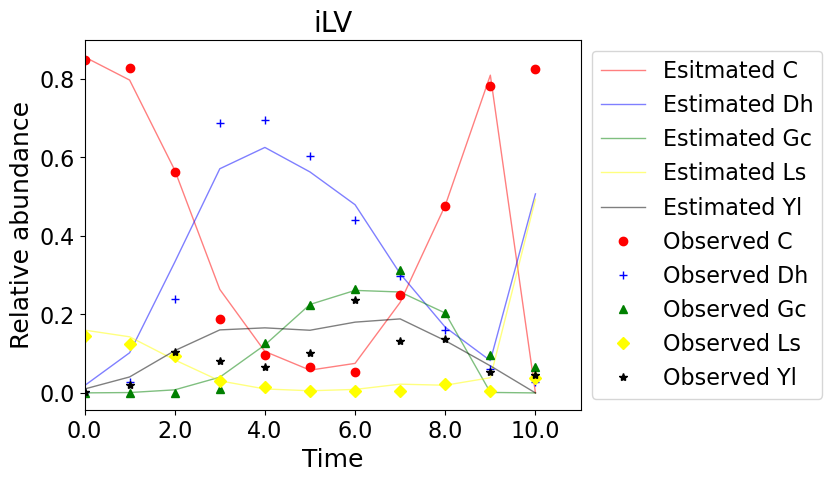

In [11]:
theta = min_theta
time = cur_time

# call Scipy's odeint function0.015, 
x_y = odeint(func=rhs, y0=theta[-6:], t=time, args=(theta,))

# plot
_, ax = plt.subplots()

plot_model(ax, x_y);
plot_data(ax)
plt.legend(fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("iLV", fontsize = 20)

#plt.title("Average distance = 3.88e-2", fontsize = 18)
plt.savefig('Fig5_1.pdf', bbox_inches='tight', dpi=300)

In [12]:
theta = theta_glvr
time = cur_time
x_y_hat = odeint(func=rhs, y0=theta[-6:], t=time, args=(theta,))
dis_one = (np.array(np.array(real_value.iloc[:, 0]) - x_y_hat[:, 0]))**2
dis_two = (np.array(np.array(real_value.iloc[:, 1]) - x_y_hat[:, 1]))**2
dis_three = (np.array(np.array(real_value.iloc[:, 2]) - x_y_hat[:, 2]))**2
dis_four = (np.array(np.array(real_value.iloc[:, 3]) - x_y_hat[:, 3]))**2
dis_five = (np.array(np.array(real_value.iloc[:, 4]) - x_y_hat[:, 4]))**2
distance_glvr = math.sqrt((np.sum(np.abs(dis_one)) + np.sum(np.abs(dis_two)) + np.sum(np.abs(dis_three)) + np.sum(np.abs(dis_four)) + np.sum(np.abs(dis_five)))/num_point/5)

In [13]:
distance_glvr

0.32706722750785616

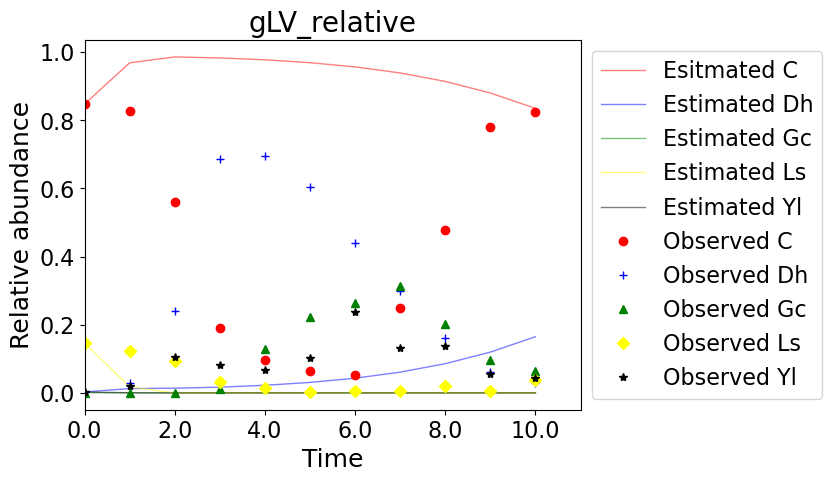

In [14]:
theta = theta_glvr
time = cur_time

# call Scipy's odeint function0.015, 
x_y = odeint(func=rhs, y0=theta[-6:], t=time, args=(theta,))

# plot
_, ax = plt.subplots()

plot_model(ax, x_y);
plot_data(ax)
plt.legend(fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("gLV_relative", fontsize = 20)

#plt.title("Average distance = 3.88e-2", fontsize = 18)
plt.savefig('Fig5_2.pdf', bbox_inches='tight', dpi=300)

In [15]:
df = pd.read_csv('../Data/cheese_absolute.csv')
data = pd.DataFrame(dict(
    n1_abs = df["C"],
    n2_abs = df["D"],
    n3_abs = df["G"],
    n4_abs = df["L"],
    n5_abs = df["Y"]
))

real = pd.DataFrame(dict(
    n1_abs = df["C"],
    n2_abs = df["D"],
    n3_abs = df["G"],
    n4_abs = df["L"],
    n5_abs = df["Y"]
))

@njit
def rhss(X, t, theta):
    # unpack parameters
    x, y, z, v, w= X
    r1, r2, r3, r4, r5, b12, b13, b14, b15, b21, b23, b24, b25, b31, b32, b34, b35, b41, b42, b43, b45, b51, b52, b53, b54, x0, y0, z0, v0, w0 = theta
    # equations
    dx_dt = r1*x + b12*x*y + b13*x*z + b14*x*v + b15*x*w
    dy_dt = r2*y + b21*x*y + b23*y*z + b24*y*v + b25*y*w
    dz_dt = r3*z + b31*x*z + b32*y*z + b34*z*v + b35*z*w
    dv_dt = r4*v + b41*v*x + b42*v*y + b43*v*z + b45*v*w
    dw_dt = r5*w + b51*w*x + b52*w*y + b53*w*z + b54*w*v
    return [dx_dt, dy_dt, dz_dt, dv_dt, dw_dt]


for i in range (num_point-1):
    data.loc[num_point+i] = (1/time_seg)*np.log(data.loc[i+1]) - (1/time_seg)*np.log(data.loc[i])


x = pd.DataFrame(data.loc[0:num_point-2, ["n2_abs", "n3_abs", "n4_abs", "n5_abs"]])
y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n1_abs"])

regr = linear_model.LinearRegression()
regr.fit(x, y)

r1_ini = regr.intercept_[0]
b12_ini = regr.coef_[0,0]
b13_ini = regr.coef_[0,1]
b14_ini = regr.coef_[0,2]
b15_ini = regr.coef_[0,3]

x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n3_abs", "n4_abs", "n5_abs"]])
y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n2_abs"])

regr = linear_model.LinearRegression()
regr.fit(x, y)

r2_ini = regr.intercept_[0]
b21_ini = regr.coef_[0,0]
b23_ini = regr.coef_[0,1]
b24_ini = regr.coef_[0,2]
b25_ini = regr.coef_[0,3]

x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n2_abs", "n4_abs", "n5_abs"]])
y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n3_abs"])

regr = linear_model.LinearRegression()
regr.fit(x, y)

r3_ini = regr.intercept_[0]
b31_ini = regr.coef_[0,0]
b32_ini = regr.coef_[0,1]
b34_ini = regr.coef_[0,2]
b35_ini = regr.coef_[0,3]

x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n2_abs", "n3_abs", "n5_abs"]])
y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n4_abs"])

regr = linear_model.LinearRegression()
regr.fit(x, y)

r4_ini = regr.intercept_[0]
b41_ini = regr.coef_[0,0]
b42_ini = regr.coef_[0,1]
b43_ini = regr.coef_[0,2]
b45_ini = regr.coef_[0,3]

x = pd.DataFrame(data.loc[0:num_point-2, ["n1_abs", "n2_abs", "n3_abs", "n4_abs"]])
y = pd.DataFrame(data.loc[num_point:2*num_point-2, "n5_abs"])

regr = linear_model.LinearRegression()
regr.fit(x, y)

r5_ini = regr.intercept_[0]
b51_ini = regr.coef_[0,0]
b52_ini = regr.coef_[0,1]
b53_ini = regr.coef_[0,2]
b54_ini = regr.coef_[0,3]

theta_abs_estimate = np.array([r1_ini, r2_ini, r3_ini, r4_ini, r5_ini, b12_ini, b13_ini, b14_ini, b15_ini, b21_ini, b23_ini, b24_ini, b25_ini, b31_ini, b32_ini, b34_ini, b35_ini, b41_ini, b42_ini, b43_ini, b45_ini, b51_ini, b52_ini, b53_ini, b54_ini, real.iloc[0, 0], real.iloc[0, 1], real.iloc[0, 2], real.iloc[0, 3], real.iloc[0, 4]])

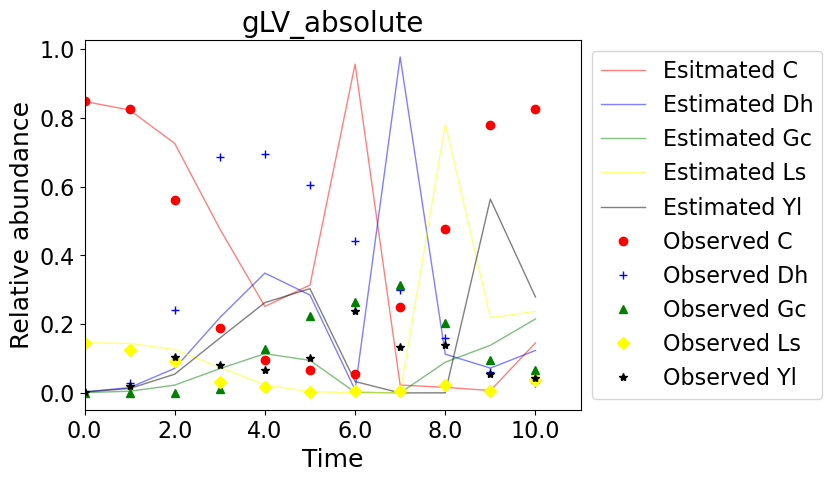

In [16]:
theta = theta_abs_estimate
time = cur_time

# call Scipy's odeint function0.015, 
x_y = odeint(func=rhss, y0=theta[-5:], t=time, args=(theta,))

x_y_rel = x_y / x_y.sum(axis=1, keepdims=True)

# plot
_, ax = plt.subplots()

plot_model(ax, x_y_rel);
plot_data(ax)
plt.legend(fontsize=16, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("gLV_absolute", fontsize = 20)
plt.savefig('Fig5_3.pdf', bbox_inches='tight', dpi=300)

In [17]:
dis_one = (np.array(np.array(real_value.iloc[:, 0]) - x_y_rel[:, 0]))**2
dis_two = (np.array(np.array(real_value.iloc[:, 1]) - x_y_rel[:, 1]))**2
dis_three = (np.array(np.array(real_value.iloc[:, 2]) - x_y_rel[:, 2]))**2
dis_four = (np.array(np.array(real_value.iloc[:, 3]) - x_y_rel[:, 3]))**2
dis_five = (np.array(np.array(real_value.iloc[:, 4]) - x_y_rel[:, 4]))**2
distance_glva = math.sqrt((np.sum(np.abs(dis_one)) + np.sum(np.abs(dis_two)) + np.sum(np.abs(dis_three)) + np.sum(np.abs(dis_four)) + np.sum(np.abs(dis_five)))/num_point/5)
distance_glva  

0.2964053607936427